In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
base_dir = 'data'
pokemon_pictures = os.listdir(os.path.join(base_dir, "pokemon_jpg"))

In [3]:
from PIL import ImageOps, Image
size = 64, 64

for f in os.listdir(os.path.join(base_dir, "pokemon_jpg")):
    im = Image.open(os.path.join(base_dir, "pokemon_jpg", f)).resize(size)
    break

big_arr = np.array([np.array(im)]).reshape(1, 64, 64, 3)
for f in os.listdir(os.path.join(base_dir,"pokemon_jpg"))[1:]:
    big_arr = np.append(big_arr, [np.array(Image.open(os.path.join(base_dir, "pokemon_jpg", f)).resize(size)).reshape(64, 64, 3)], axis=0)

big_arr = big_arr/255

(-0.5, 63.5, 63.5, -0.5)

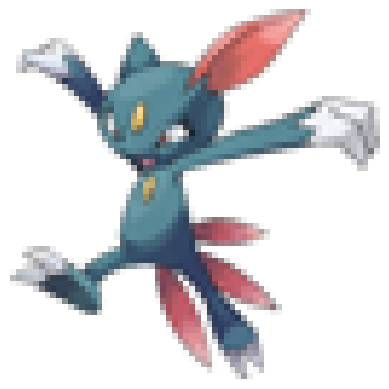

In [4]:
X_train = big_arr[:600]
X_test = big_arr[600:800]

plt.imshow(big_arr[0])
plt.axis('off')

In [5]:
N, H, W = X_train.shape[:-1]
D = H *W
# Flattening the data
X_train = X_train.reshape(-1, D)
X_test = X_test.reshape(-1, D)

In [6]:
latent_dim = 100 # Dimansinality of latent space

In [7]:
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation='tanh')(x) # -1 and 1 values used

    model = Model(i, x)
    return model

In [8]:
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(i, x)
    return model

In [9]:
discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise to get image
img = generator(z)

# Making sure only generator is trainable
discriminator.trainable = False

# True output is fake yet we label as real
fake_pred = discriminator(img)

combined_model = Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
batch_size = 32
epochs = 30000
sample_period = 200 # Every step generate and save some data

# Creating batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Storing loss
d_losses = []
g_losses = []

if not os.path.exists('data'):
    os.makedirs('data')

In [11]:
def sample_image(epochs):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Scaling images to 0-1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i, j].axis('off')
            idx += 1
    fig.savefig('data' %epochs)
    plt.close()

In [ ]:
# Training loop

# Training discriminator
for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_imgs = X_train[idx]

    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    # Train generator
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print((epoch+1)/epochs, d_loss, d_acc, g_loss)

    if epoch % sample_period == 0:
        sample_image(epoch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


3.3333333333333335e-05 0.4551999866962433 0.8125 [array(0.5447242, dtype=float32), array(0.5447242, dtype=float32), array(0.625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━